#Classification predict Climate Change


<img src="https://climate.nasa.gov/system/internal_resources/details/original/103_shutterstock_88550854-740px.jpg" width=90%>

#1. Introduction

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

The task of this notebook is to create a Machine Learning model(s) that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Being able to provide an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.


#2. Importing liabraries

In [19]:
# utilities
import numpy as np
import pandas as pd
import seaborn as sns

# plotting
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
sns.set()

# nltk
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
import nltk
import re

# sklearn(classifier)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

#Metrics/Evaluation
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics


In [20]:
!pip install wordcloud

In [21]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> l
Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Assessment of Information
                           Extraction Systems in Biology)
  [ ] bllip_wsj_no_aux.... BLLIP Parser: WSJ Model
  [ ] book_grammars....... Grammars from NLTK Book
  [ ] brown............... Brown Corpus
  [ ] brown_tei........... Brown Corpus (TEI XML Version)
  [ ] cess_cat............ CESS-CAT Treebank
  [

True

# 3. Uploading the dataset

In [22]:
# Reading the csv datasets into pandas dataframes
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [23]:
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [24]:
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


#4. Exploratory Data Analysis

# Dataset


*  The uploaded datasets are train and the test dataset, the train dataset contain three columns which are sendiment,  tweet message and tweetid while the test dataset contains the tweet message and the tweetid column.


*   The sediment column  has four classes which are represented by four numbers 2, 1, 0, -1, the following picture shows the description of the four classes:


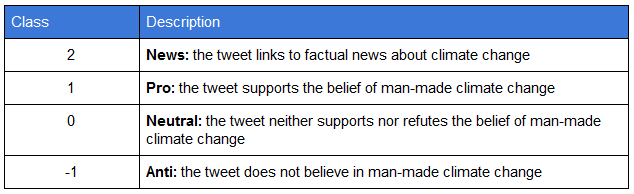

#The distribution of tweets messages over the classes

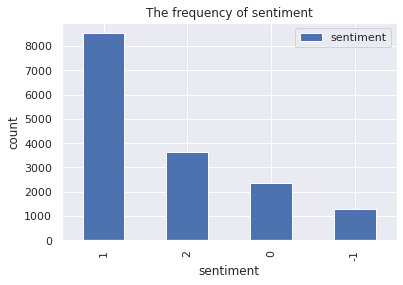

In [25]:
train['sentiment'].value_counts().plot(kind ='bar')
plt.title ('The frequency of sentiment')
plt.ylabel('count')
plt.xlabel('sentiment')
plt.legend()
plt.show()

*   From the above graph we can conlude that the distribution of tweets messages are unevenly distributed in the four given classes, this  affects the accuracy of the model.

*   The imbalance of the classes can be solved by the method called resampling (Downscalling and Upscalling) which  involve modifying the number of observations in each class .

#5. Data Preprocessing

 Data preprocessing is a step where we transforms text into a more digestible form so that machine learning algorithms can perform better.The following steps were performed for both the train and the test dataset.
* Checking for nuls: Checking for any nulls in the datasets
* Checking for blanks strings: Checking for any blanks strings in the datasets
* Replacing URLs: Links starting with "http" or "https" or "www" are replaced by "URL".
* Lower Casing: Each text is converted to lowercase.
* Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence.
* Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “Great” to “Good”)





###5.1 Checking for nulls in he dataframes

In [26]:
# Checking Nulls in the train dataframe
train.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [27]:
# Checking Nulls in the test dataframe
test.isnull().sum()

message    0
tweetid    0
dtype: int64

###5.2 Checking for blanks in he dataframes

In [28]:
#Checking for blanks in the train dataframe
blanks = []  # start with an empty list

for i,sen,mes,twe in train.itertuples():  # iterate over the DataFrame
    if type(mes)==str:            # avoid NaN values
        if mes.isspace():         # test 'review' for whitespace
            blanks.append(i)     # add matching index numbers to the list
        
print(len(blanks), 'blanks: ', blanks)

0 blanks:  []


In [29]:
#Checking for blanks in the train dataframe
blanks = []  # start with an empty list

for i,mes,twe in test.itertuples():  # iterate over the DataFrame
    if type(mes)==str:            # avoid NaN values
        if mes.isspace():         # test 'review' for whitespace
            blanks.append(i)     # add matching index numbers to the list
        
print(len(blanks), 'blanks: ', blanks)

0 blanks:  []


###5.3 Replacing URL

In [30]:
# Describing patterns
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
# Apply replace method on train and test data
train['message'] = train['message'] .replace(to_replace = pattern_url, value = subs_url, regex = True)
test['message'] = test['message'] .replace(to_replace = pattern_url, value = subs_url, regex = True)

###5.4 Removing stopwords, lowering the words as well as lemmatizing  for both the train and the test dataframe

In [31]:
# Download nltk stopwords lib
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [32]:
# Set instances
stop_words = set(stopwords.words("english")) 

lemmatizer = WordNetLemmatizer()

# Function clean_text to pre_process the data
def clean_text(text):
    text = re.sub('<[^<]+?>','', text)
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

# Create new column for clean/processed messages
train['Processed_message'] = train.message.apply(lambda x: clean_text(x))

test['Processed_message'] = test.message.apply(lambda x: clean_text(x))


In [33]:
# Checking the preprossed train dataframe 
train.head()


,sentiment,message,tweetid,Processed_message
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warm
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt rawstory researcher say three year act clim...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wire 2016 wa pivotal year war cl...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt soynoviodetodas 2016 racist sexist climate ...


In [34]:
# Checking the preprossed test dataframe 
test.head()

,message,tweetid,Processed_message
0,Europe will now be looking to China to make su...,169760,europe look china make sure alone fight climat...
1,Combine this with the polling of staffers re c...,35326,combine poll staffer climate change woman righ...
2,"The scary, unimpeachable evidence that climate...",224985,scary unimpeachable evidence climate change al...
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,karoli morgfair osborneink dailykos \nputin ge...
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,rt fakewillmoore female orgasm cause global wa...


# WordCloud

Word Clouds for News,Pro, Netral and Anti tweet messages  from our train dataset and see which words occur the most.

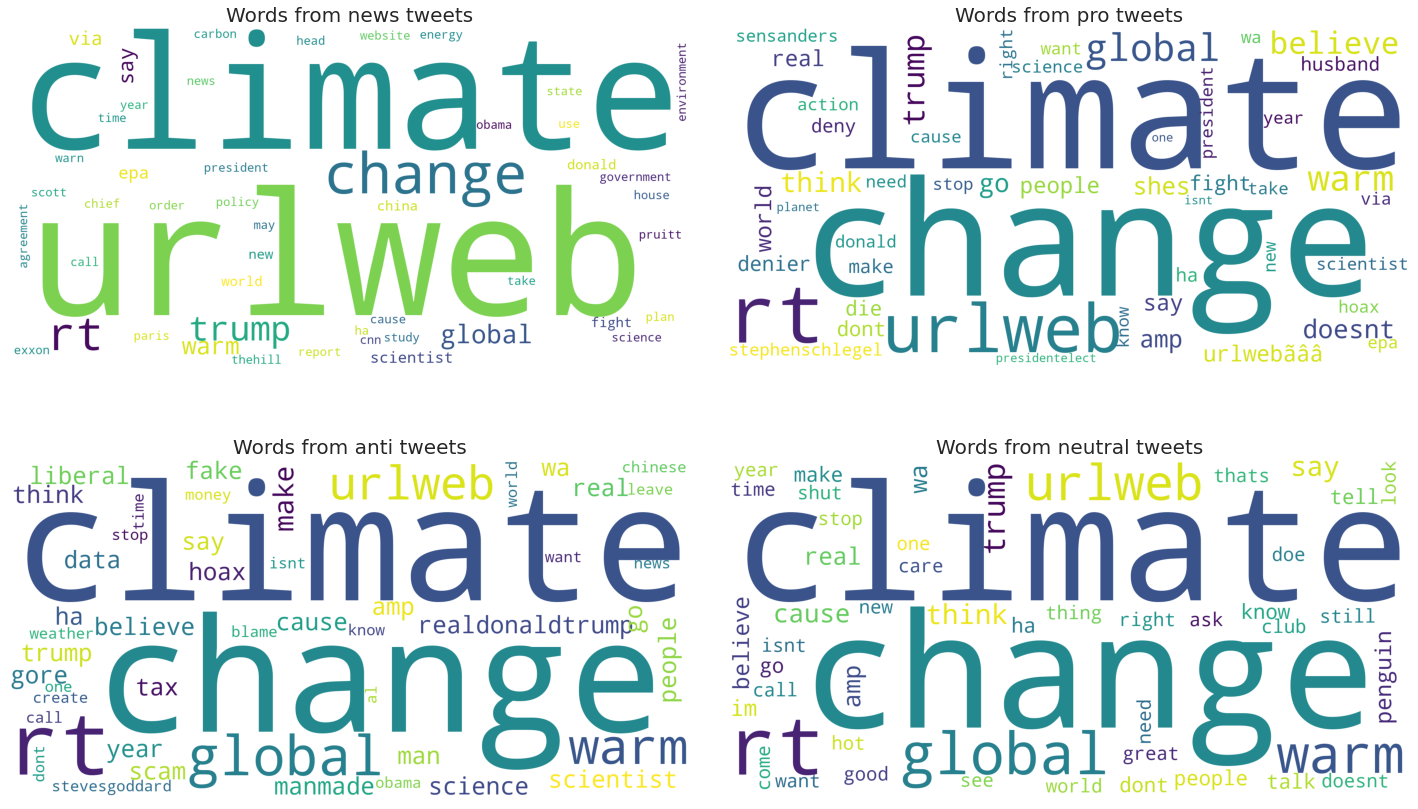

In [39]:
#Plotting word clouds
news = train[train['sentiment'] == 2]['Processed_message']
pro = train[train['sentiment'] == 1]['Processed_message']
neutral =train[train['sentiment'] == 0]['Processed_message']
Anti = train[train['sentiment'] ==-1]['Processed_message']


news = [word for line in news for word in line.split()]
pro = [word for line in pro for word in line.split()]
neutral = [word for line in neutral for word in line.split()]
Anti= [word for line in Anti for word in line.split()]

news = WordCloud(
    background_color='white',
    max_words=50,
    max_font_size=100,
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(news))

pro = WordCloud(
    background_color='white',
    max_words=50,
    max_font_size=100,
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(pro))



neutral = WordCloud(
    background_color='white',
    max_words=50,
    max_font_size=100,
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(neutral))


Anti = WordCloud(
    background_color='white',
    max_words=50,
    max_font_size=100,
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(Anti))


fig, axs = plt.subplots(2, 2, figsize = (20, 12))
# fig.suptitle('Clouds of polar words', fontsize = 30)
fig.tight_layout(pad = 0)

axs[0, 0].imshow(news)
axs[0, 0].set_title('Words from news tweets', fontsize = 20)
axs[0, 0].axis('off')
# axs[0, 0].tight_layout(pad = 1)

axs[0, 1].imshow(pro)
axs[0, 1].set_title('Words from pro tweets', fontsize = 20)
axs[0, 1].axis('off')
# axs[0, 1].tight_layout(pad = 1)


# axs[1, 0].tight_layout(pad = 1)
axs[1, 0].imshow(Anti)
axs[1, 0].set_title('Words from anti tweets', fontsize = 20)
axs[1, 0].axis('off')

axs[1, 1].imshow(neutral)
axs[1, 1].set_title('Words from neutral tweets', fontsize = 20)
axs[1, 1].axis('off')

# axs[1, 0].tight_layout(pad = 1)
plt.savefig('joint_cloud.png')

#Machine Learning

Now we employ machine-learning technique and diverse features to construct a classifier that can identify text/messages that expresses sentiment.

#6. Defining variables

In [40]:
#Independent feature of the train dataframe
X=train['Processed_message']
#Dependent feature of the train dataframe
y=train['sentiment'] 
#Independent feature of test dataframe
x_unseen=test['Processed_message'] #test independent feature

#7. Splitting the dataset

The Preprocessed Data is divided into 2 sets of data:

*   Training Data: The dataset upon which the model would be trained on. Contains 90% data. 
*   Test Data: The dataset upon which the model would be tested against. Contains 10% data.




In [41]:
#Splitting the train dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#8. Model fitting


##8.1 Parameters  and TF-IDF Vectoriser explanation
**TF-IDF Vectoriser**
TF-IDF indicates what the importance of the word is in order to understand the document or dataset.

TF-IDF Vectoriser converts a collection of raw documents to a matrix of TF-IDF features.

**ngram_range** is the range of number of words in a sequence.

**max_df** Used for removing data values that appear too frequently.

**min_df** Used for removing terms that appear too infrequently.


##8.2 Models Descriptions

We have chosen the following models to train and test our data:
1. **Logistic Regression:**
Logistic regression is a statistical model that in its basic form uses a logistic function to model the probability of a certain class 

2. **LineasrSVC:**
Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and  scale better to large numbers of samples.This class supports both dense and sparse input and the multiclass support is handled according to a one-vs-the-rest scheme.

3. **Multinomial Naive Bayes:** 
Naive Bayes classifier for multinomial models. The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

4. **Support Vector Machine:**
The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.we have used the rbf kernel, which allows the SVC to fit a non-linear decision boundary. 


##8.3 Pipelines for fitting the models

###8.3.1 Logistic Regression Model

In [42]:
text_clf = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', 
                             min_df=1, 
                             max_df=0.9, 
                             ngram_range=(1, 2))),
                     ('LG',LogisticRegression()),
])
#Fitting the model with train dataset
text_clf.fit(X_train, y_train)  

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.9, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('LG',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_sca

In [43]:
# Getting predicions from the X_test
predictions = text_clf.predict(X_test)
#Pritting the classification report
print(metrics.classification_report(y_test,predictions))
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

              precision    recall  f1-score   support

          -1       0.80      0.35      0.49       126
           0       0.67      0.33      0.45       224
           1       0.76      0.88      0.82       895
           2       0.73      0.80      0.76       337

    accuracy                           0.75      1582
   macro avg       0.74      0.59      0.63      1582
weighted avg       0.74      0.75      0.73      1582

0.7458912768647282


###8.3.2 LinearSVC Model

In [ ]:
text_clf1 = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', 
                             min_df=1, 
                             max_df=0.9, 
                             ngram_range=(1, 2))),
                     ('LS',LinearSVC()),
])
#Fitting the model with train dataset
text_clf1.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.9, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('LS',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
           

In [ ]:
# Getting predicions from the X_test
predictions1 = text_clf1.predict(X_test)
#Printing the classification report
print(metrics.classification_report(y_test, predictions1))
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions1))

              precision    recall  f1-score   support

          -1       0.70      0.50      0.58       126
           0       0.66      0.38      0.48       224
           1       0.79      0.87      0.83       895
           2       0.75      0.83      0.79       337

    accuracy                           0.76      1582
   macro avg       0.72      0.65      0.67      1582
weighted avg       0.75      0.76      0.75      1582

0.7629582806573957


###8.3.3 Support Vector Machine Model

In [ ]:
text_clf2 = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', 
                             min_df=1, 
                             max_df=0.9, 
                             ngram_range=(1, 2))),
                     ('SV', SVC(kernel='rbf')),
])
#Fitting the model with train dataset
text_clf2.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.9, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('SV',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr',

In [ ]:
# Getting predictions from the X_test
predictions2 = text_clf2.predict(X_test)
#Pritting the classification report
print(metrics.classification_report(y_test,predictions2))
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions2))

              precision    recall  f1-score   support

          -1       0.89      0.32      0.47       126
           0       0.79      0.29      0.43       224
           1       0.73      0.91      0.81       895
           2       0.76      0.78      0.77       337

    accuracy                           0.75      1582
   macro avg       0.79      0.58      0.62      1582
weighted avg       0.76      0.75      0.72      1582

0.7484197218710493


###8.3.4 Multinominal Naive Bayes Model

In [ ]:
text_clf3 = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', 
                             min_df=1, 
                             max_df=0.9, 
                             ngram_range=(1, 2))),
                     ('MT', MultinomialNB()),
])
#Fitting the model with train dataset
text_clf3.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.9, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('MT',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
# Getting predictions from the X_test
predictions3 = text_clf3.predict(X_test)
#Priting the classification report
print(metrics.classification_report(y_test,predictions3))
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions3))

              precision    recall  f1-score   support

          -1       1.00      0.04      0.08       126
           0       1.00      0.03      0.06       224
           1       0.63      0.99      0.77       895
           2       0.92      0.45      0.60       337

    accuracy                           0.66      1582
   macro avg       0.89      0.38      0.38      1582
weighted avg       0.77      0.66      0.58      1582

0.661188369152971


#Evaluation metrics

As a classification problem, Sentiment Analysis uses the evaluation metrics of Precision, Recall, F-score, and Accuracy. Also, average measures like macro, micro, and weighted F1-scores are useful for multi-class problems. 

#Visualise Results

To visualize the results of Sentiment Analysis,we employ techniques, such as graphs, histograms, and confusion matrices.

#9. Conclusion
Based on the accuracy scores from the four  fitted models above, LinearSCV is the one which gives a higher score than the rest implyng that is the best model to use to predict the sentiment of the tweet messages. Based on the model description on 8.2 it states that LinearSCV supports both dense and sparse input and the multiclass  is handled according to a one-vs-the-rest ,this is the reason why is the best model.

#10. Predicting the sentiment from the test dataset based on the best model

In [ ]:
#Getting the predicted sentimet from test dataset
y_pred = text_clf1.predict(x_unseen)

In [ ]:
#Printing the predicted sentiment
y_pred

array([1, 1, 1, ..., 2, 0, 1], dtype=int64)

#11. Submissions

In [ ]:
#Making the tweetid to be the idex
test=test.set_index('tweetid')

In [ ]:
test.head(5)

,message,Processed_message
tweetid,,
169760,Europe will now be looking to China to make su...,europe look china make sure alone fight climat...
35326,Combine this with the polling of staffers re c...,combine poll staffer climate change woman righ...
224985,"The scary, unimpeachable evidence that climate...",scary unimpeachable evidence climate change al...
476263,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,karoli morgfair osborneink dailykos \nputin ge...
872928,RT @FakeWillMoore: 'Female orgasms cause globa...,rt fakewillmoore female orgasm cause global wa...


In [ ]:
#Sellecting the index of the test dataframe
final_test= test.index

In [ ]:
#Creating the submission Dataframe
Final_Table = {'tweetid': final_test, 'sentiment':np.round(y_pred, 0)}
submission = pd.DataFrame(data=Final_Table)
submission = submission[['tweetid', 'sentiment']]

In [ ]:
submission.set_index('tweetid').head(5)

,sentiment
tweetid,
169760,1
35326,1
224985,1
476263,1
872928,0


In [ ]:
submission.to_csv("TestSubmission7.csv",index  = False) #wrting csv file

In [ ]:
import pickle